### 1. Process the raw data downloaded from the GBIF website

The sample can be downloaded from https://www.gbif.org/occurrence/download/0000223-250117142028555

Please place the unzip file in the ./data/tutorial/ folder

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd())) # Add parent directory to path

import torch
import numpy as np
import pandas as pd
import glob

def process_data(filename, global_genus_idx, genus_thres = 20, grid_thres = 2):
    # Load and clean data
    data = pd.read_csv(filename, delimiter='\t')
    data = data.dropna(subset=['genus', 'decimalLongitude', 'decimalLatitude'])
    
    # Extract coordinates and genus data
    X = data[['decimalLongitude', 'decimalLatitude', 'genus']].values
    
    # Process genus data
    unique_k, counts = np.unique(X[:, 2], return_counts=True)
    frequent_k = unique_k[counts > genus_thres]
    local_genus_idx = {k: idx for idx, k in enumerate(frequent_k)}
    
    # Update global genus index
    for genus in local_genus_idx:
        if genus not in global_genus_idx:
            global_genus_idx[genus] = len(global_genus_idx)
            
    # Convert to global indices
    X[:, 2] = np.vectorize(lambda x: global_genus_idx.get(x, -1))(X[:, 2])
    X = X[X[:, 2] != -1]

    # Set up grid parameters
    grid_size = 0.1
    min_x, max_x = int(X[:, 0].min()), int(X[:, 0].max())
    min_y, max_y = int(X[:, 1].min()), int(X[:, 1].max())
    grid_size_x = int(np.ceil((max_x - min_x) / grid_size))
    grid_size_y = int(np.ceil((max_y - min_y) / grid_size))
    x_range = np.linspace(min_x, max_x, grid_size_x)
    y_range = np.linspace(min_y, max_y, grid_size_y)

    # Create and populate grid
    grid_data = np.zeros((grid_size_x, grid_size_y, len(global_genus_idx)))
    for x, y, k in X:
        x_idx = np.argmin(np.abs(x_range - x))
        y_idx = np.argmin(np.abs(y_range - y))
        k_idx = int(k)
        grid_data[x_idx, y_idx, k_idx] = min(grid_data[x_idx, y_idx, k_idx] + 1, 1)

    # Process grid data
    grid_mask = (grid_data.sum(axis=-1) > grid_thres).flatten()
    grid_data = grid_data.reshape(-1, grid_data.shape[2])
    grid_data_masked = grid_data[grid_mask]

    # Create coordinate tensors
    x_coords, y_coords = np.meshgrid(x_range, y_range, indexing='ij')
    coords_flat = np.vstack((x_coords.flatten(), y_coords.flatten())).T
    coords_flat_masked = coords_flat[grid_mask]

    return grid_data_masked, coords_flat_masked


global_genus_idx = {}
# path for the unzipped file
filename = '../data/tutorial/0000223-250117142028555.csv'

# Process first file to initialize
result, coords = process_data(filename, global_genus_idx)

print(f"Final results shape: {result.shape}")
print(f"Total genus processed: {len(global_genus_idx)}")

np.save('../data/tutorial/tutorial_training.npy', result)
np.save('../data/tutorial/tutorial_coords.npy', coords)

C:\Users\TriCityPC\AppData\Local\Temp\ipykernel_10688\3451081716.py:12: DtypeWarning: Columns (14,16,38,39,40,41,43,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename, delimiter='\t')


Final results shape: (2613, 520)
Total genus processed: 520


### 2. training model

In [10]:
!python ../training.py -i ../data/tutorial/tutorial_training.npy -o ../model/tutorial_model.pth

Using device: cuda
Loading data from ../data/tutorial/tutorial_training.npy
loading data shape is (2613, 520)
Data split: 2351 training samples, 262 evaluation samples
Epoch [1/15], Loss: 9.9449
Eval set MSE loss: 19.0923
Epoch [2/15], Loss: 9.2881
Eval set MSE loss: 17.3442
Epoch [3/15], Loss: 7.8882
Eval set MSE loss: 24.9534
Epoch [4/15], Loss: 7.0667
Eval set MSE loss: 19.3205
Epoch [5/15], Loss: 6.9271
Eval set MSE loss: 20.7413
Epoch [6/15], Loss: 6.9867
Eval set MSE loss: 23.5712
Epoch [7/15], Loss: 6.5255
Eval set MSE loss: 20.9323
Epoch [8/15], Loss: 6.8596
Eval set MSE loss: 18.3711
Epoch [9/15], Loss: 7.1274
Eval set MSE loss: 18.2108
Epoch [10/15], Loss: 6.2054
Eval set MSE loss: 20.5286
Epoch [11/15], Loss: 6.4670
Eval set MSE loss: 21.3577
Epoch [12/15], Loss: 6.4817
Eval set MSE loss: 18.3667
Epoch [13/15], Loss: 7.3470
Eval set MSE loss: 18.4967
Epoch [14/15], Loss: 6.0960
Eval set MSE loss: 18.4660
Epoch [15/15], Loss: 6.3149
Eval set MSE loss: 19.1114
Model saved to .

### 3. calculate prediction error

In [4]:
from model import VAE

## load data
result = np.load('../data/tutorial/tutorial_training.npy')
coords = np.load('../data/tutorial/tutorial_coords.npy')

# Load the model and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set hyperparameters
input_dim = result.shape[1]
hidden_dim = 256
latent_dim = 32
output_dim = result.shape[1]
masking_ratio = 0.5
lambda_weight = 0.5

# Create VAE model
model = VAE(input_dim, hidden_dim, latent_dim, output_dim).cuda()

# Print the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the VAE model: {num_params}")

model_path = '../model/tutorial_model.pth'
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)

## load data
result = np.load('../data/tutorial/tutorial_training.npy')
coords = np.load('../data/tutorial/tutorial_coords.npy')

Using device: cuda
Number of parameters in the VAE model: 423496


In [5]:
def calculate_error(result, model, batch_size=2048):
    # Convert input to tensor
    x_train = torch.tensor(result, dtype=torch.float32)
    num_samples = x_train.size(0)
    recon_x_list_nomask = []
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            # Process batch
            batch = x_train[i:i+batch_size].cuda()
            recon_x_nomask, _, _ = model(batch)
            recon_x_list_nomask.append(recon_x_nomask.cpu())
    
    # Concatenate results
    recon_x_nomask = torch.cat(recon_x_list_nomask, dim=0)
    
    # Calculate input mean
    input_mean = np.mean(x_train.numpy(), axis=1)
    
    # Find optimal threshold
    optimal_threshold = find_threshold(recon_x_nomask.numpy(), input_mean)
    
    # Calculate final mean ratio
    np_no_mask = recon_x_nomask.numpy() > optimal_threshold
    overlap = np.mean(np_no_mask & x_train.numpy().astype(bool), axis=1)
    error = 1 - np.divide(overlap, input_mean)
    
    return error

def find_threshold(recon_x_nomask, input_mean, tolerance=1e-6, max_iterations=100):
    target = 2 * np.mean(input_mean)
    low, high = 0.0, 1.0
    
    for _ in range(max_iterations):
        mid = (low + high) / 2
        current_mask = recon_x_nomask > mid
        current_mean = np.mean(current_mask)
        
        if abs(current_mean - target) < tolerance:
            return mid
            
        if current_mean > target:
            low = mid
        else:
            high = mid
            
    return (low + high) / 2

error = calculate_error(result, model)

### 4. plot prediction error

Note: you may need to restart the kernel to use updated packages.


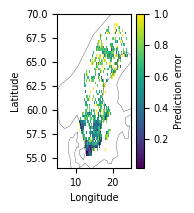

In [8]:
%pip install pyshp

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import shapefile  # pyshp
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Ensure selected_coords is an array and not a list
selected_coords = np.array(coords)
selected_mean_ratio = np.array(error)

# Ensure selected_coords has data
if selected_coords.shape[0] == 0:
    print("No data points fall within the specified range.")
else:
    # Check if there are matching lengths for weights and coordinates
    assert selected_coords.shape[0] == selected_mean_ratio.shape[0], "Mismatch in data lengths."

    # Compute the 2D binned statistic (mean values within each bin)
    statistic, x_edges, y_edges, _ = binned_statistic_2d(
        selected_coords[:, 0],  # Longitudes
        selected_coords[:, 1],  # Latitudes
        selected_mean_ratio,
        statistic='mean',
        bins=[240, 240]
    )

    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)

    # Prepare the plot with the specified figure size
    fig, ax = plt.subplots(figsize=(1.4, 2))
    # Plot using pcolormesh
    im = ax.pcolormesh(X, Y, statistic.T, cmap='viridis', shading='auto')

    # Add colorbar with font size adjustments
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label('Prediction error', fontsize=7)

    # Read the shapefile (replace 'path_to_shapefile' with your actual path)
    shapefile_path = "../data/tutorial/ne_110m_land.shp"
    sf = shapefile.Reader(shapefile_path)

    # Get the shapes
    shapes = sf.shapes()

    # Create a list to store the polygons
    polygons = []

    # Loop through the shapes
    for shape in shapes:
        points = shape.points
        parts = list(shape.parts) + [len(points)]  # Add end point
        # Loop through parts to get individual polygons
        for i in range(len(parts) - 1):
            start = parts[i]
            end = parts[i + 1]
            segment = points[start:end]
            # Create a polygon and add it to the list
            polygon = Polygon(segment, closed=True)
            polygons.append(polygon)

    # Create a PatchCollection and add it to the plot
    p = PatchCollection(polygons, facecolor='none', edgecolor='black', linewidths=0.2)
    ax.add_collection(p)

    # Set limits to match the data
    ax.set_xlim(5, 25)
    ax.set_ylim(54, 70)

    # Set labels and title with font size 7
    ax.set_xlabel('Longitude', fontsize=7)
    ax.set_ylabel('Latitude', fontsize=7)
    ax.set_title('', fontsize=7)

    # Adjust tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=7)
    plt.show()